<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/mobile2.png?raw=true" width=800 align="left"/>

# 실습 내용

- 다양한 알고리즘으로 모델을 만들고 성능을 예측합니다.
- 성능이 좋을 것으로 판단된 모델의 성능을 튜닝합니다.
- 튜닝된 모델의 성능을 평가합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [16]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

In [17]:
# 데이터 불러오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data['CHURN'] = data['CHURN'].map({'STAY':0, 'LEAVE': 1}) #XGBoost와 LightGBM은 sklearn게 아니라 label이 문자형일 경우 오류남

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [18]:
# 데이터 살펴보기
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,2,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,3,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,4,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,5,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


**데이터 설명**

- COLLEGE: 대학 졸업여부
- INCOME: 연수입
- OVERAGE: 월평균 초과사용 시간(분)
- LEFTOVER: 월평균 잔여시간비율(%)
- HOUSE: 집값
- HANDSET_PRICE: 스마트폰 가격
- OVER_15MINS_CALLS_PER_MONTH: 월평균 장기통화(15분이상) 횟수
- AVERAGE_CALL_DURATION: 평균 통화 시간
- REPORTED_SATISFACTION: 만족도 설문조사 결과
- REPORTED_USAGE_LEVEL: 사용도 자가진단 결과
- CONSIDERING_CHANGE_OF_PLAN: 향후 변경계획 설문조사 결과
- CHURN: 이탈(번호이동) 여부

In [19]:
# 기술통계 확인
data.describe()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,CHURN
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.502400,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250,0.492600
std,5773.647028,0.500007,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558,0.499958
min,1.000000,0.000000,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000,0.000000
25%,5000.750000,0.000000,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000,0.000000
50%,10000.500000,1.000000,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000,0.000000
75%,15000.250000,1.000000,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000,1.000000
max,20000.000000,1.000000,159983.000000,335.000000,89.000000,999996.000000,899.000000,29.000000,15.000000,1.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 변수 제거**

In [20]:
# 제거 대상: id
drop_col = 'id'

# 변수 제거
data.drop(drop_col, axis=1, inplace=True)

# 확인
data

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,153252,0,23,368403,597,1,6,very_sat,little,actively_looking_into_it,0
19996,1,107126,71,82,237397,609,5,2,very_sat,very_little,no,0
19997,0,78529,0,66,172589,275,0,2,unsat,very_high,considering,1
19998,0,78674,47,41,572406,288,4,2,very_unsat,little,considering,1


**2) x, y 분리**

In [21]:
# Target 설정
target='CHURN'

# 데이터 분리
x = data.drop(target, axis=1)
y = data.loc[:, target]

**3) 가변수화**

In [22]:
# 가변수화 대상: REPORTED_SATISFACTION, REPORTED_USAGE_LEVEL, CONSIDERING_CHANGE_OF_PLAN
dum_cols = ['REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']

# 가변수화
x = pd.get_dummies(x, dum_cols, drop_first=True, dtype=int)

# 확인
x

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0,31953,0,6,313378,161,0,4,0,1,0,0,0,1,0,0,0,0,1,0
1,1,36147,0,13,800586,244,0,6,0,1,0,0,0,1,0,0,1,0,0,0
2,1,27273,230,0,305049,201,16,15,0,1,0,0,0,0,0,1,0,0,0,1
3,0,120070,38,33,788235,780,3,2,0,1,0,0,0,0,1,0,1,0,0,0
4,1,29215,208,85,224784,241,21,1,0,0,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,153252,0,23,368403,597,1,6,0,0,1,0,0,1,0,0,0,0,0,0
19996,1,107126,71,82,237397,609,5,2,0,0,1,0,0,0,0,1,0,0,1,0
19997,0,78529,0,66,172589,275,0,2,0,1,0,0,0,0,1,0,1,0,0,0
19998,0,78674,47,41,572406,288,4,2,0,0,0,1,0,1,0,0,1,0,0,0


**4) 학습용, 평가용 데이터 분리**

In [23]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

**5) 정규화**

In [25]:
# 모듈 불러오기
from sklearn.preprocessing import MinMaxScaler

# 정규화
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

# 4.성능 예측

- 여러 알고리즘으로 모델을 만들고 K-Fold CV로 성능을 예측합니다.
- 하이퍼파라미터를 설정하지 않고 진행합니다.
- 각 모델의 성능 정보를 수집해 마지막에 비교합니다.

In [ ]:
# xgboost 설치
# !pip install xgboost

In [ ]:
# lightgbm 설치
# !pip install lightgbm

- 이후 사용할 함수를 모두 불러옵니다.

In [26]:
# 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

**1) KNN**

- KNN 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [59]:
# 선언하기
knn_model = KNeighborsClassifier()

In [60]:
# 성능예측
cv_score= cross_val_score(knn_model, x_train_s, y_train)

In [61]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.58571429 0.60035714 0.57785714 0.60321429 0.59785714]
0.5930000000000001


In [62]:
# 결과수집
result = {}
result['KNN'] = cv_score.mean()

**2) Decision Tree**

- Decision Tree 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [63]:
# 선언하기
tree_model = DecisionTreeClassifier(random_state=1)

In [64]:
# 성능예측
cv_score = cross_val_score(tree_model, x_train, y_train)

In [65]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.61607143 0.61392857 0.60642857 0.6125     0.62714286]
0.6152142857142857


In [66]:
# 결과수집
result['Decision Tree'] = cv_score.mean()

**3) Logistic Regression**

- Logistic Regression 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [67]:
# 선언하기
logi_model = LogisticRegression(random_state=1)

In [68]:
# 성능예측
cv_score= cross_val_score(logi_model, x_train, y_train)

In [69]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.62714286 0.63714286 0.6225     0.6425     0.635     ]
0.6328571428571429


In [70]:
# 결과수집
result['Logistic Regression'] = cv_score.mean()

**4) Random Forest**

- Random Forest 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [71]:
# 선언하기
forest_model = RandomForestClassifier(random_state=1)

In [72]:
# 성능예측
cv_score = cross_val_score(forest_model, x_train, y_train)

In [73]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.69035714 0.69821429 0.68357143 0.69678571 0.69321429]
0.6924285714285714


In [74]:
# 결과수집
result['Random Forest'] = cv_score.mean()

**5) XGBoost**

- XGBoost 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [81]:
# 선언하기
xg_model = XGBClassifier(random_state=1)

In [82]:
# 성능예측
cv_score = cross_val_score(xg_model, x_train, y_train)

In [83]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.67857143 0.69607143 0.67892857 0.69285714 0.68678571]
0.6866428571428573


In [84]:
# 결과수집
result['XGBoost'] = cv_score.mean()

**6) LightGBM**

- LightGBM 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [100]:
# 선언하기
light_model = LGBMClassifier(verbose=-1, random_state=1, importance_type='gain')

In [101]:
# 성능예측
cv_score = cross_val_score(light_model, x_train, y_train)

In [102]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.68785714 0.71428571 0.68321429 0.6975     0.69821429]
0.6962142857142857


In [103]:
# 결과수집
result['LightGBM'] = cv_score.mean()

# 5.결과 확인

- 예측된 각 모델의 성능을 비교합니다.

In [136]:
# 성능 비교
print('=' * 40)
for m_name, score in result.items():
    print('*', m_name, score.round(3))
print('=' * 40)

* KNN 0.593
* Decision Tree 0.615
* Logistic Regression 0.633
* Random Forest 0.692
* XGBoost 0.687
* LightGBM 0.696


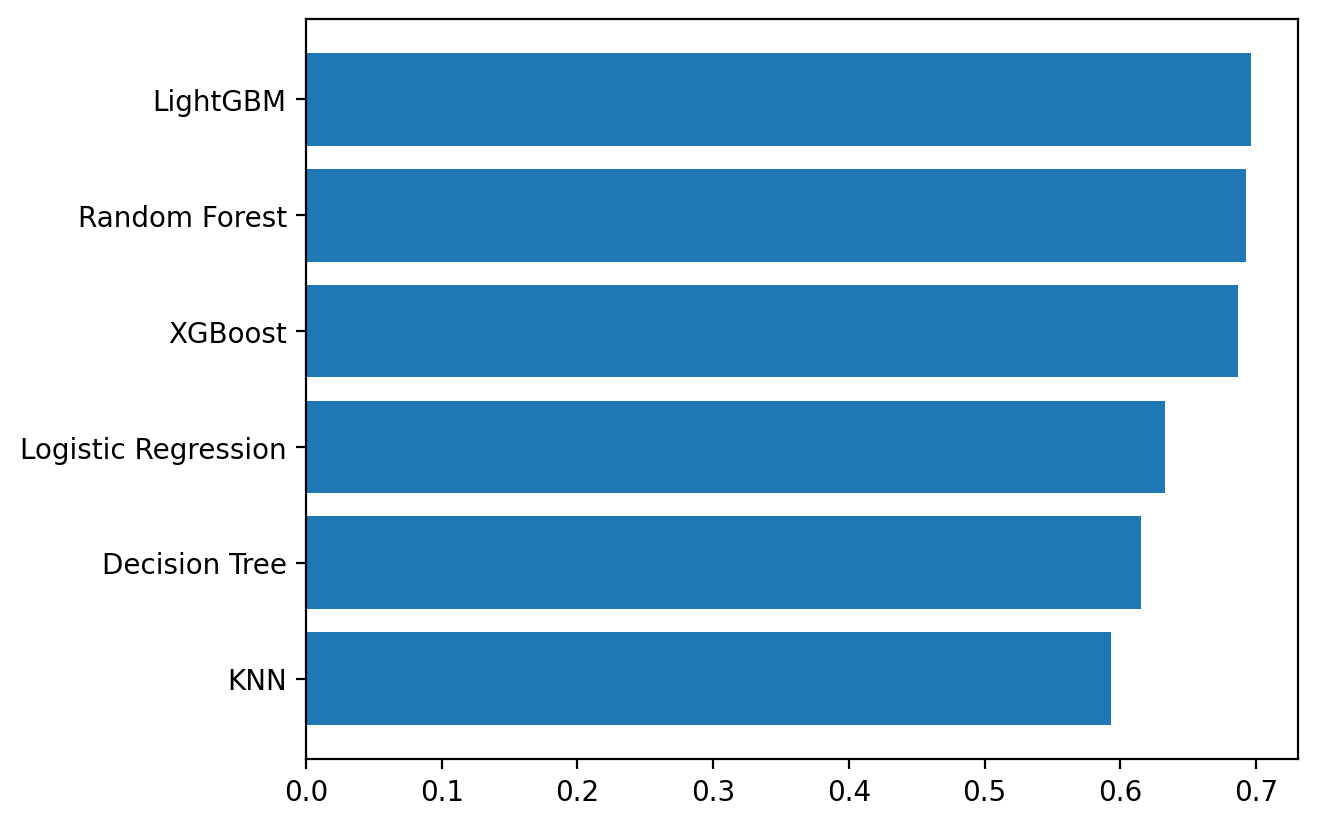

In [127]:
# 성능 시각화 비교
df = pd.DataFrame()
df['models'] = result.keys()
df['accuracy'] = result.values()
df.sort_values(by='accuracy', inplace=True)
plt.barh(df['models'], df['accuracy'])
plt.show()

# 6.성능 튜닝

- 위에서 성능이 가장 좋을 것으로 예측된 모델을 튜닝합니다.
- 본 실습에서는 LightGBM 모델 성능을 튜닝합니다.

In [106]:
# 파라미터 지정
  # max_depth: range(1, 21)
param = {'max_depth': range(1, 21)}

# 모델 선언
model = GridSearchCV(light_model, param, scoring='accuracy')

In [107]:
# 학습하기(많은 시간이 소요될 수 있음)
model.fit(x_train, y_train)

GridSearchCV(estimator=LGBMClassifier(importance_type='gain', random_state=1,
                                      verbose=-1),
             param_grid={'max_depth': range(1, 21)}, scoring='accuracy')

In [108]:
# 최적 파라미터, 예측 최고 성능
print(model.best_params_)
print(model.best_score_)

{'max_depth': 6}
0.6980000000000001


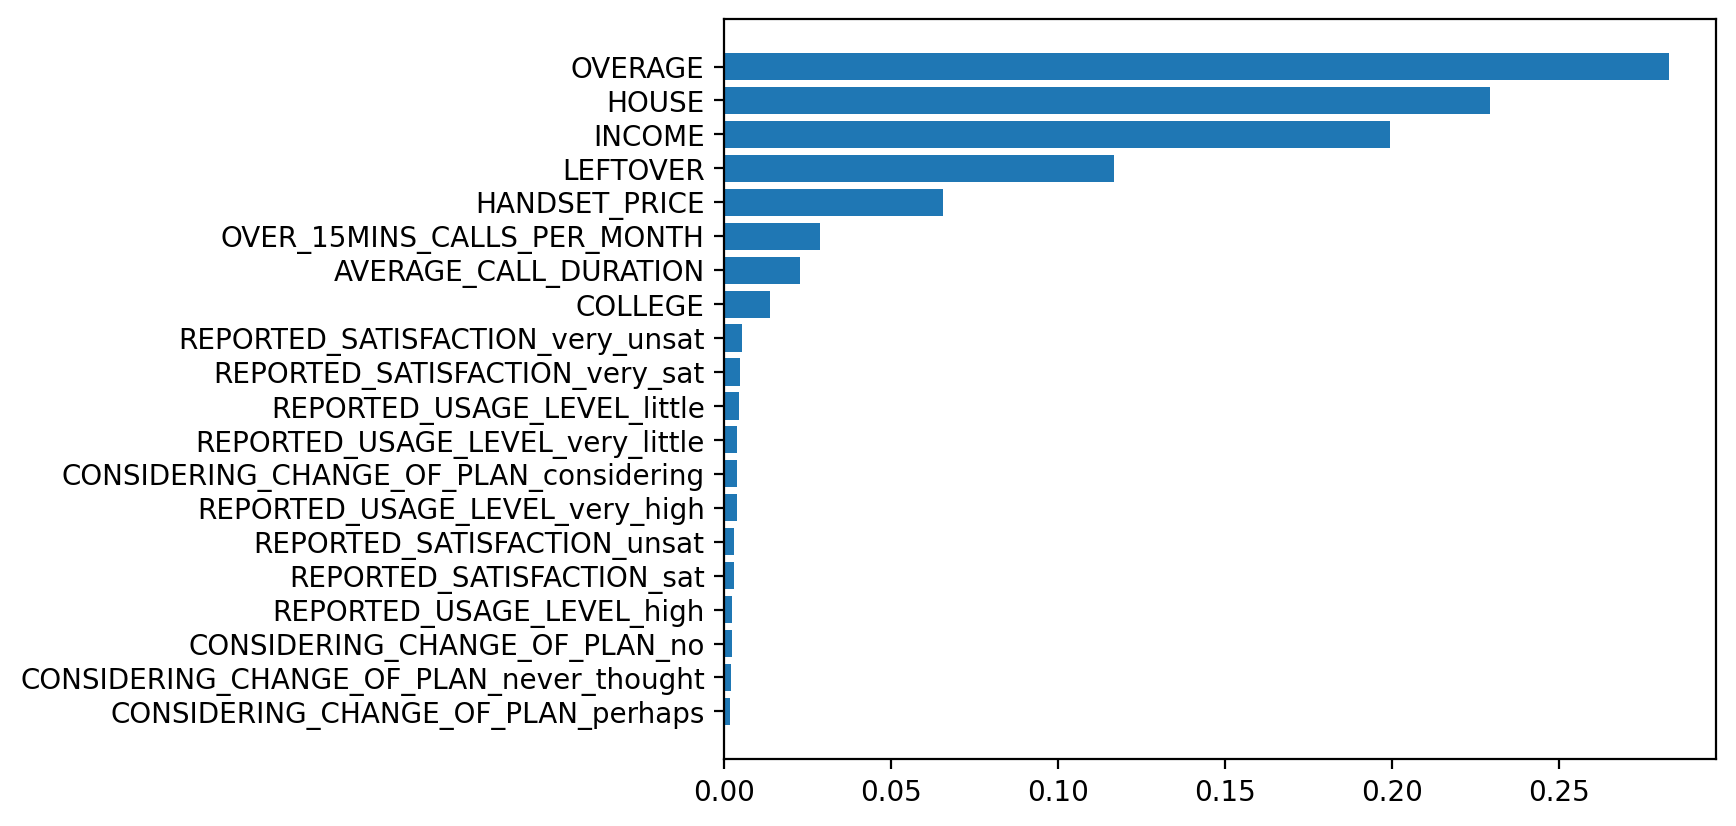

In [130]:
# 성능 시각화 비교
df = pd.DataFrame()
df['feature'] = list(x)
df['feature_importances'] = model.best_estimator_.feature_importances_ /  np.sum(model.best_estimator_.feature_importances_)
df.sort_values(by='feature_importances', inplace=True)
plt.barh(df['feature'], df['feature_importances'])
plt.show()

# 7.성능 평가

- 최적 파라미터로 학습된 모델에 대해 최종 성능 평가를 진행합니다.

In [110]:
# 예측하기
y_pred = model.predict(x_test)

In [111]:
# 성능평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1953 1112]
 [ 747 2188]]
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      3065
           1       0.66      0.75      0.70      2935

    accuracy                           0.69      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.69      0.69      0.69      6000

